In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures


In [5]:
dataset = pd.read_csv('/kaggle/input/cars-dataset/cars.csv')
dataset.head()
final_results_r2 = {}
final_results_mse = {}

In [6]:
currency_prices = {
    "SAR": 0.27,
    "EGP": 0.032,
    "BHD": 2.65,
    "QAR": 0.27,
    "OMR": 2.60,
    "KWD": 3.25,
    "AED": 0.27
}

valid_price_pattern = r'^([A-Z]{3})\s([\d,]+)$'
dataset['currency'] = dataset['price'].str.extract(r'^([A-Z]{3})')[0]
dataset['price_numeric'] = dataset['price'].str.extract(r'([\d,]+)$')[0]
dataset['price_numeric'] = dataset['price_numeric'].str.replace(',', '', regex=False).astype(float, errors='ignore')


dataset['price_usd'] = dataset.apply(
    lambda row: row['price_numeric'] * currency_prices[row['currency']]
    if row['currency'] in currency_prices else None,
    axis=1
)

dataset = dataset.dropna(subset=['price_usd'])
dataset['engine_capacity'] = pd.to_numeric(dataset['engine_capacity'], errors='coerce')


for col in ['cylinder', 'horse_power', 'top_speed', 'seats']:
    dataset[col] = dataset[col].str.extract(r'(\d+\.?\d*)')[0].astype(float, errors='ignore')


numeric_cols = ['engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats']
dataset[numeric_cols] = dataset[numeric_cols].apply(lambda col: col.fillna(col.mean()))

LE = LabelEncoder()
dataset['brand'] = LE.fit_transform(dataset['brand'])
dataset['country'] = LE.fit_transform(dataset['country'])


dataset = dataset.drop(columns=['price', 'currency', 'price_numeric', 'car name'])
numerical_cols = ['engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats', 'price_usd']


scaler = StandardScaler()
dataset[numerical_cols] = scaler.fit_transform(dataset[numerical_cols])

In [7]:
train_full, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_data, validation_data = train_test_split(train_full, test_size=0.25, random_state=42)

# 60 20 20
print(f"Training Data: {train_data.shape}")
print(f"validation_ Data: {validation_data.shape}")
print(f"Test Data: {test_data.shape}")

Training Data: (2987, 8)
validation_ Data: (996, 8)
Test Data: (996, 8)


In [8]:
dataset.head()

,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country,price_usd
1,-0.233832,-0.732338,-0.576018,-3.177871,0.206789,61,2,-0.317966
2,-0.234919,-0.732338,-1.000699,-1.049585,-0.142617,72,2,-0.423376
3,-0.233180,-0.732338,0.730692,-3.240010,0.112158,25,2,-0.173118
5,-0.234267,-0.732338,-0.793803,-0.350513,-0.069824,32,2,-0.432078
6,-0.233832,-0.732338,-0.902696,-0.661211,0.000000,61,2,-0.463583


In [9]:
select = 0 
output_label = None

if select == 0:
    output_label = 'price_usd'
else:
    output_label = 'top_speed'
    
X_train = train_data.drop(columns=[output_label])
y_train = train_data[output_label]

X_validation_ = validation_data.drop(columns=[output_label])
y_validation_ = validation_data[output_label]

X_test = test_data.drop(columns=[output_label])
y_test = test_data[output_label]


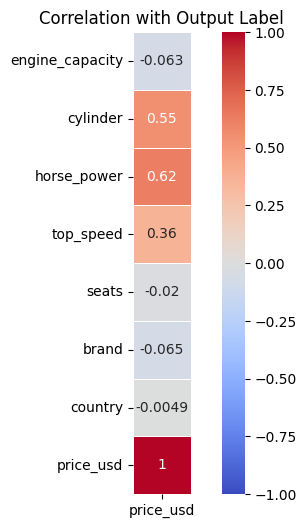

In [10]:
correlation_matrix = dataset.corr()
correlation_with_outputLabel = correlation_matrix[[output_label]]

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_with_outputLabel, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, square=True, linewidths=0.5)
plt.title('Correlation with Output Label')
plt.show()

In [11]:
# Linear Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)


y_validation_pred = linear_model.predict(X_validation_)
validation_mse = mean_squared_error(y_validation_, y_validation_pred)
validation_mae = mean_absolute_error(y_validation_, y_validation_pred)
validation_r2 = r2_score(y_validation_, y_validation_pred)
print(f"validation_ MSE: {validation_mse}, MAE: {validation_mae}, R^2: {validation_r2}")

final_results_r2['linear'] = validation_r2
final_results_mse['linear'] = validation_mse


validation_ MSE: 0.6371148260887837, MAE: 0.26542143944536156, R^2: 0.29785856854825665


{0.001: 0.6361230192123971, 0.01: 0.6280490077742203, 0.1: 0.5813667697732887, 1: 0.9060170264684536, 10: 0.9073882454770604, 100: 0.9073882454770604}
Best Alpha (validation_): 0.1
validation_ MSE: 0.5813667697732887, MAE: 0.22699762508014604, R^2: 0.3592965047870209


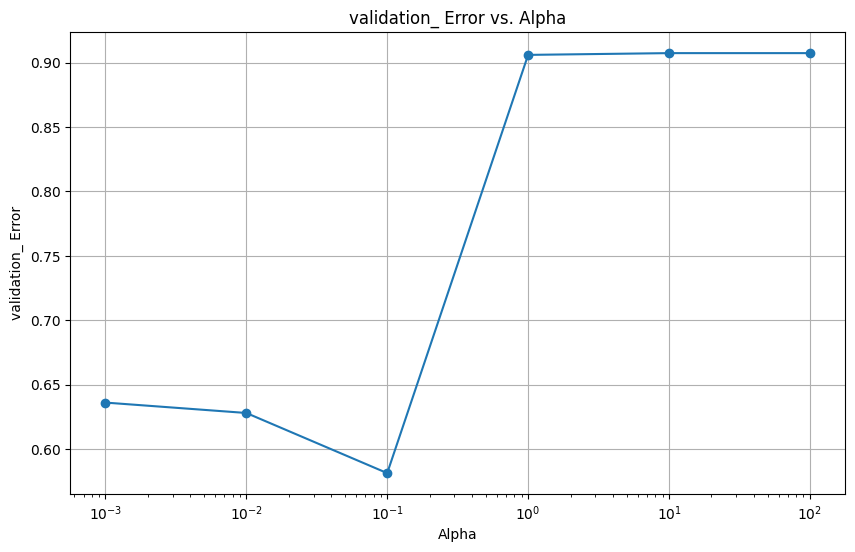

In [12]:
# Lasso + Grid Search

alphas = [0.001, 0.01, 0.1, 1, 10, 100]

validation_errors = {}


for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, max_iter=10000)
    lasso_model.fit(X_train, y_train)
    y_validation_pred = lasso_model.predict(X_validation_)
    validation_mse = mean_squared_error(y_validation_, y_validation_pred)
    validation_errors[alpha] = validation_mse

print(validation_errors)
best_alpha_manual = min(validation_errors, key=validation_errors.get)
print(f"Best Alpha (validation_): {best_alpha_manual}")

lasso_model = Lasso(alpha=best_alpha_manual, max_iter=10000)
lasso_model.fit(X_train, y_train)

y_validation_pred = lasso_model.predict(X_validation_)
validation_mse = mean_squared_error(y_validation_, y_validation_pred)
validation_mae = mean_absolute_error(y_validation_, y_validation_pred)
validation_r2 = r2_score(y_validation_, y_validation_pred)
final_results_r2['lasso'] = validation_r2
final_results_mse['lasso'] = validation_mse
print(f"validation_ MSE: {validation_mse}, MAE: {validation_mae}, R^2: {validation_r2}")


param_values = list(validation_errors.keys())
error_values = list(validation_errors.values())

plt.figure(figsize=(10, 6))
plt.plot(param_values, error_values, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('validation_ Error')
plt.title('validation_ Error vs. Alpha')
plt.grid(True)
plt.show()


{0.001: 0.637114396675044, 0.01: 0.6371105320629167, 0.1: 0.6370718969801458, 1: 0.6366866472187638, 10: 0.6329415374931056, 100: 0.6040383905767224}
Best Alpha (validation_): 100
validation_ MSE: 0.6040383905767224, MAE: 0.25650904829055476, R^2: 0.3343109234876842


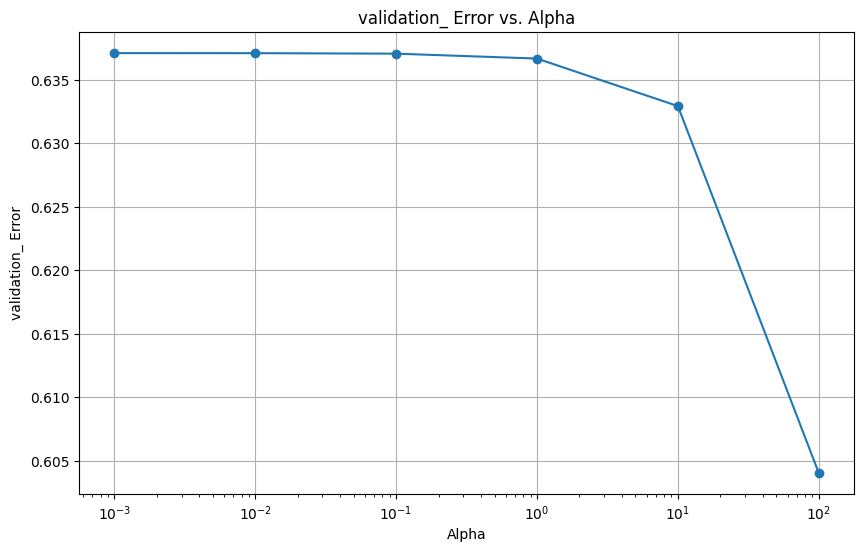

In [13]:
# Linear + Ridge + Grid Search

alphas = [0.001, 0.01, 0.1, 1, 10, 100]
validation_errors = {}

for alpha in alphas:
    ridge_model = Ridge(alpha=alpha, max_iter=10000)
    ridge_model.fit(X_train, y_train)
    y_validation_pred = ridge_model.predict(X_validation_)
    validation_mse = mean_squared_error(y_validation_, y_validation_pred)
    validation_errors[alpha] = validation_mse

print(validation_errors)
best_alpha_manual = min(validation_errors, key=validation_errors.get)
print(f"Best Alpha (validation_): {best_alpha_manual}")

ridge_model = Ridge(alpha=best_alpha_manual, max_iter=10000)
ridge_model.fit(X_train, y_train)

y_validation_pred_ridge = ridge_model.predict(X_validation_)
validation_mse_ridge = mean_squared_error(y_validation_, y_validation_pred_ridge)
validation_mae_ridge = mean_absolute_error(y_validation_, y_validation_pred_ridge)
validation_r2_ridge = r2_score(y_validation_, y_validation_pred_ridge)
final_results_r2['ridge'] = validation_r2_ridge
final_results_mse['ridge'] = validation_mse_ridge
print(f"validation_ MSE: {validation_mse_ridge}, MAE: {validation_mae_ridge}, R^2: {validation_r2_ridge}")

param_values = list(validation_errors.keys())
error_values = list(validation_errors.values())
plt.figure(figsize=(10, 6))
plt.plot(param_values, error_values, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('validation_ Error')
plt.title('validation_ Error vs. Alpha')
plt.grid(True)
plt.show()

In [14]:
def add_bias_term(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

X_train_scaled = standardize(X_train)
X_validation_scaled = standardize(X_validation_)
X_train_bias = add_bias_term(X_train_scaled)
X_validation_bias = add_bias_term(X_validation_scaled)


theta_closed_form = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train
y_validation_pred_closed_form = X_validation_bias @ theta_closed_form

validation_mse_closed_form = np.mean((y_validation_ - y_validation_pred_closed_form) ** 2)
validation_mae_closed_form = np.mean(np.abs(y_validation_ - y_validation_pred_closed_form))
validation_r2_closed_form = 1 - (np.sum((y_validation_ - y_validation_pred_closed_form) ** 2) /
                          np.sum((y_validation_ - np.mean(y_validation_)) ** 2))

print("Closed-Form Solution Results:")
print(f"validation_ MSE: {validation_mse_closed_form}")
print(f"validation_ MAE: {validation_mae_closed_form}")
print(f"validation_ R^2: {validation_r2_closed_form}")

final_results_r2['closed-form'] = validation_r2_closed_form
final_results_mse['closed-form'] = validation_mse_closed_form


Closed-Form Solution Results:
validation_ MSE: 0.5614194792234884
validation_ MAE: 0.2249226301894296
validation_ R^2: 0.3812796992862003


In [15]:
def add_bias_term(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])


def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std


X_train_scaled = standardize(X_train)
X_validation_scaled = standardize(X_validation_)
X_train_bias = add_bias_term(X_train_scaled)
X_validation_bias = add_bias_term(X_validation_scaled)

theta_gd = np.zeros(X_train_bias.shape[1])
learning_rate = 0.001
num_iterations = 1000
m = X_train_bias.shape[0]


for i in range(num_iterations):
    predictions = X_train_bias @ theta_gd
    gradient = (1 / m) * (X_train_bias.T @ (predictions - y_train))
    theta_gd -= learning_rate * gradient
    if np.isnan(theta_gd).any():
        print("NaN encountered in weights, stopping iteration")
        break

y_validation_pred_gd = X_validation_bias @ theta_gd
validation_mse_gd = np.mean((y_validation_ - y_validation_pred_gd) ** 2)
validation_mae_gd = np.mean(np.abs(y_validation_ - y_validation_pred_gd))
validation_r2_gd = 1 - (np.sum((y_validation_ - y_validation_pred_gd) ** 2) /
                 np.sum((y_validation_ - np.mean(y_validation_)) ** 2))

print("\nGradient Descent Results:")
print(f"validation_ MSE: {validation_mse_gd}")
print(f"validation_ MAE: {validation_mae_gd}")
print(f"validation_ R^2: {validation_r2_gd}")

final_results_r2['gradient-descent'] = validation_r2_gd
final_results_mse['gradient-descent'] = validation_mse_gd



Gradient Descent Results:
validation_ MSE: 0.5537845493039663
validation_ MAE: 0.23569067472846694
validation_ R^2: 0.3896938821041339


In [16]:
print("\nComparison of Closed-Form and Gradient Descent:")
print(f"Closed-Form MSE: {validation_mse_closed_form}, Gradient Descent MSE: {validation_mse_gd}")
print(f"Closed-Form MAE: {validation_mae_closed_form}, Gradient Descent MAE: {validation_mae_gd}")
print(f"Closed-Form R^2: {validation_r2_closed_form}, Gradient Descent R^2: {validation_r2_gd}")



Comparison of Closed-Form and Gradient Descent:
Closed-Form MSE: 0.5614194792234884, Gradient Descent MSE: 0.5537845493039663
Closed-Form MAE: 0.2249226301894296, Gradient Descent MAE: 0.23569067472846694
Closed-Form R^2: 0.3812796992862003, Gradient Descent R^2: 0.3896938821041339


In [17]:
svr = SVR(kernel='rbf')

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10]
}

grid_search_svr = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_svr.fit(X_train, y_train)


best_params_svr = grid_search_svr.best_params_
print(f"Best Parameters for SVR: {best_params_svr}")

rbf_model = SVR(kernel='rbf', C=best_params_svr['C'], gamma=best_params_svr['gamma'])
rbf_model.fit(X_train, y_train)
y_validation_pred_svr = rbf_model.predict(X_validation_)
validation_mse_svr = mean_squared_error(y_validation_, y_validation_pred_svr)
validation_mae_svr = mean_absolute_error(y_validation_, y_validation_pred_svr)
validation_r2_svr = r2_score(y_validation_, y_validation_pred_svr)

final_results_r2['rbf'] = validation_r2_svr
final_results_mse['rbf'] = validation_mse_svr

print(f"RBF Kernel SVR validation_ Performance: MSE={validation_mse_svr:.2f}, MAE={validation_mae_svr:.2f}, R^2={validation_r2_svr:.2f}")

Best Parameters for SVR: {'C': 100, 'gamma': 0.01}
RBF Kernel SVR validation_ Performance: MSE=0.11, MAE=0.13, R^2=0.88


In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation_)

poly_results = {}

for degree in range(2, 11):
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_validation_poly = poly.transform(X_validation_scaled)
    
    model = Ridge(alpha=best_alpha_manual)
    model.fit(X_train_poly, y_train)
    y_validation_pred = model.predict(X_validation_poly)
    
    validation_mse = mean_squared_error(y_validation_, y_validation_pred)
    validation_mae = mean_absolute_error(y_validation_, y_validation_pred)
    validation_r2 = r2_score(y_validation_, y_validation_pred)
    
    poly_results[degree] = {"MSE": validation_mse, "MAE": validation_mae, "R2": validation_r2}
    print(f"Degree {degree}: MSE={validation_mse:.2f}, MAE={validation_mae:.2f}, R^2={validation_r2:.2f}")


Degree 2: MSE=19.51, MAE=0.31, R^2=-20.50
Degree 3: MSE=0.18, MAE=0.18, R^2=0.80
Degree 4: MSE=107625.79, MAE=10.61, R^2=-118609.53
Degree 5: MSE=66322053.44, MAE=258.20, R^2=-73091158.76
Degree 6: MSE=41474676637.56, MAE=6455.78, R^2=-45707755698.34


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.27405e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Degree 7: MSE=15566045339100.21, MAE=125038.68, R^2=-17154781067541.60


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=7.99034e-21): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


Degree 8: MSE=3513146304943712.00, MAE=1878225.01, R^2=-3871712718719302.50


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Degree 9: MSE=2482430129965134.50, MAE=1578769.39, R^2=-2735797337558367.00


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Degree 10: MSE=50716107947663576.00, MAE=7135871.25, R^2=-55892406162702144.00


In [19]:
model = rbf_model

In [20]:
selectected_features = []  # List to store selectected features
remaining_features = list(X_train.columns)  # Features to evaluate
best_validation_mse = float('inf')  # Track the best validation_ MSE
max_features = len(X_train.columns)  # Optional limit


In [21]:
svr = SVR(kernel='rbf', C=100, gamma=0.01)  
final_model = None  # Variable to store the final best model

# Perform Forward selectection
for step in range(max_features):
    feature_performance = {}

    print(f"\nStep {step + 1}: Evaluating features to add...")
    
    for feature in remaining_features:
        temp_features = selectected_features + [feature]
        X_train_temp = X_train[temp_features]
        X_validation_temp = X_validation_[temp_features]

        svr.fit(X_train_temp, y_train)

        y_validation_pred = svr.predict(X_validation_temp)

        mse = mean_squared_error(y_validation_, y_validation_pred)
        feature_performance[feature] = mse

        print(f"Feature: {feature}, validation_ MSE: {mse:.2f}")

    best_feature = min(feature_performance, key=feature_performance.get)
    best_feature_mse = feature_performance[best_feature]

    if best_feature_mse < best_validation_mse:
        selectected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_validation_mse = best_feature_mse
        print(f"\nStep {step + 1} Decision: Added {best_feature}, which had the lowest validation_MSE: {best_validation_mse:.2f}")
    else:
        print(f"\nStopping Forward selectection at Step {step + 1}: No improvement in validation_MSE.")
        break

# Store the final model trained on selectected features
final_model = SVR(kernel='rbf', C=100, gamma=0.01)  
X_train_final = X_train[selectected_features]
final_model.fit(X_train_final, y_train)

print("\nFinal Model stored successfully.")
print(f"selectected Features: {selectected_features}")



Step 1: Evaluating features to add...
Feature: engine_capacity, validation_ MSE: 0.93
Feature: cylinder, validation_ MSE: 0.67
Feature: horse_power, validation_ MSE: 0.31
Feature: top_speed, validation_ MSE: 0.63
Feature: seats, validation_ MSE: 0.91
Feature: brand, validation_ MSE: 0.85
Feature: country, validation_ MSE: 0.95

Step 1 Decision: Added horse_power, which had the lowest validation_ MSE: 0.31

Step 2: Evaluating features to add...
Feature: engine_capacity, validation_ MSE: 0.27
Feature: cylinder, validation_ MSE: 0.30
Feature: top_speed, validation_ MSE: 0.20
Feature: seats, validation_ MSE: 0.23
Feature: brand, validation_ MSE: 0.15
Feature: country, validation_ MSE: 0.27

Step 2 Decision: Added brand, which had the lowest validation_ MSE: 0.15

Step 3: Evaluating features to add...
Feature: engine_capacity, validation_ MSE: 0.15
Feature: cylinder, validation_ MSE: 0.14
Feature: top_speed, validation_ MSE: 0.14
Feature: seats, validation_ MSE: 0.14
Feature: country, vali

In [22]:
X_test_min = X_test[selectected_features]
final_model_predications = final_model.predict(X_test_min)
validation_mse_svr = mean_squared_error(y_test, final_model_predications)
validation_mae_svr = mean_absolute_error(y_test, final_model_predications)
validation_r2_svr = r2_score(y_test, final_model_predications)

print(f"Final Model on Testing Data:\n MSE: {validation_mse_svr}, MAE: {validation_mae_svr}, R^2: {validation_r2_svr}")

Final Model on Testing Data:
 MSE: 0.9282336570918032, MAE: 0.16260240185946917, R^2: 0.5543091430287449


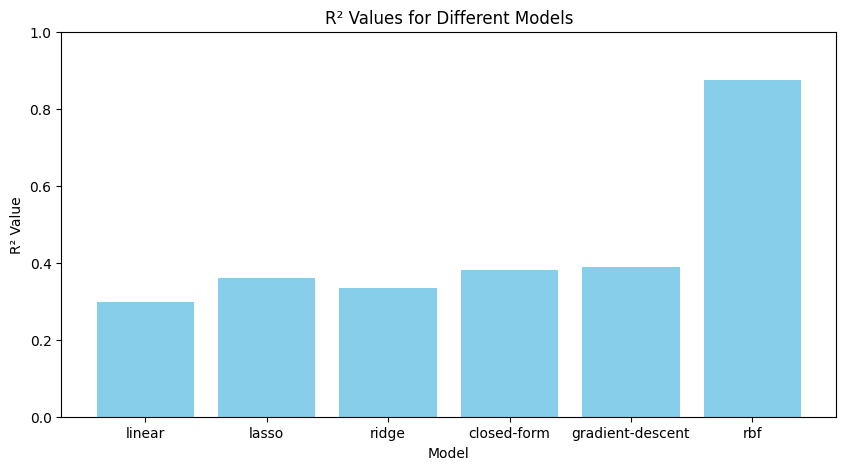

In [23]:
# Plot R² values
plt.figure(figsize=(10, 5))
plt.bar(final_results_r2.keys(), final_results_r2.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('R² Value')
plt.title('R² Values for Different Models')
plt.ylim(0, 1)  # Assuming R² values are between 0 and 1
plt.show()


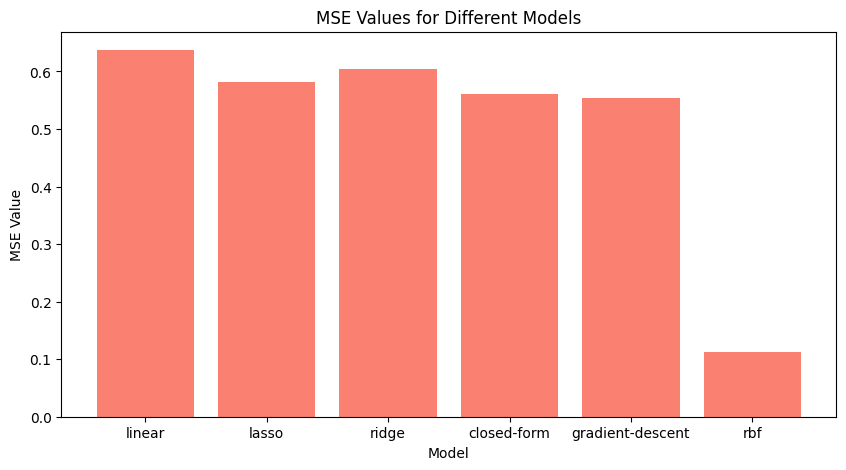

In [24]:
# Plot MSE values
plt.figure(figsize=(10, 5))
plt.bar(final_results_mse.keys(), final_results_mse.values(), color='salmon')
plt.xlabel('Model')
plt.ylabel('MSE Value')
plt.title('MSE Values for Different Models')
plt.show()
